# Looking through the galaxies

In this tutorial we'll be looking at a particular spectra of the so-called ``Green pea`` galaxy observed by SDSS and will focus on the parameter extraction aspect of the fitter class in `pyMultiFit` library.

The file can be directly obtained from SDSS [direct link](https://dr17.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=293&mjd=51994&fiberid=78).

## Sloan Digital Sky Survey
The **Sloan Digital Sky Survey (SDSS)** is one of the most ambitious and influential astronomical surveys ever conducted. 
Launched in 2000, it aims to map the Universe in unprecedented detail using a 2.5-meter telescope at Apache Point Observatory in New Mexico, USA.
SDSS has collected high-quality optical and infrared imaging and spectroscopic data for millions of stars, galaxies, and quasars. Its surveys include:

1. Imaging: Capturing detailed maps of the sky to measure positions, shapes, and colors of celestial objects.
2. Spectroscopy: Measuring redshifts to determine distances and velocities, providing a 3D map of the Universe.

Notable achievements of SDSS include:

1. Galaxy Redshift Surveys: Helping t3o map large-scale cosmic structures, like filaments and voids.
2. Quasar Studies: Identifying and studying distant quasars and black holes.
3. Stellar Astronomy: Providing detailed data on stars in the Milky Way for understanding its structure and formation.

SDSS data has been made publicly available, revolutionizing research in astronomy and astrophysics and fostering numerous discoveries about the cosmos.

## Reading the ``.fits`` file

The SDSS data comes packaged in the standard ``.fits`` format that can be read using the ``astropy.io`` package.

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

from pymultifit.fitters import GaussianFitter

sdss_spectra = fits.open('./spec-0293-51994-0078.fits')

The SDSS file contains data of different types in different headers.

1. The first header contains data about the wavelength and flux of the object in observation.
2. The second header contains information about the redshift measurements of the object.
3. The third header contains information about the spectral lines for the object.

In [2]:
head1 = sdss_spectra[1]
head2 = sdss_spectra[2]
head3 = sdss_spectra[3]

flux = head1.data['flux']  # flux from header 1
log_lam = head1.data['loglam']  # log(wavelength) from header 1
z = head2.data['Z']  # redshift from header 2

The wavelength for observations are recorded as log(wavelength) so to obtain the actual values of the wavelength, we can perform an anti-log operation on it.

In [3]:
# Compute wavelength and rest wavelength using the redshift parameter
wavelength = 10**log_lam
rest_wavelength = wavelength / (1 + z)

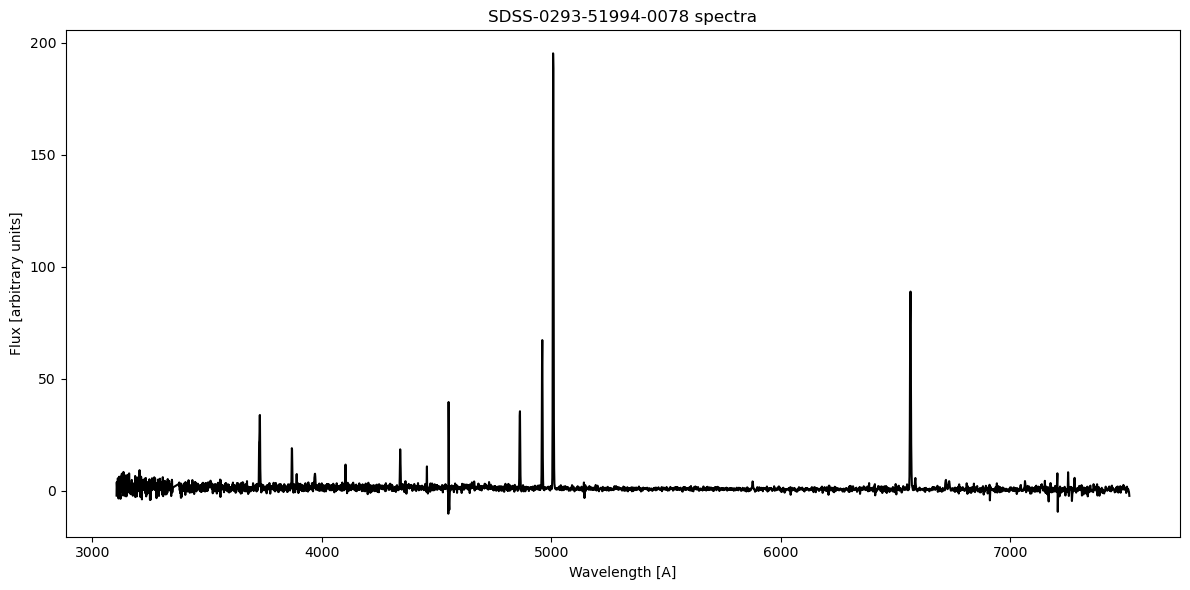

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(rest_wavelength, flux, 'k')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [arbitrary units]')
plt.title('SDSS-0293-51994-0078 spectra')
plt.tight_layout()

Since the spectrum has been redshift corrected, we can now look for some specific spectra lines and try to fit them with gaussian profile, see [SDSS link](https://classic.sdss.org/dr6/algorithms/linestable.php)

1. $H_\alpha \sim 6563\,A$,\ $H_\beta \sim 4862\,A$
2. ``O[III]`` at $4932.603\,A$, $4960.295\,A$, and $5008.240\,A$
3. ``N[II]`` at $6549.86\,A$ and $6585.27\,A$

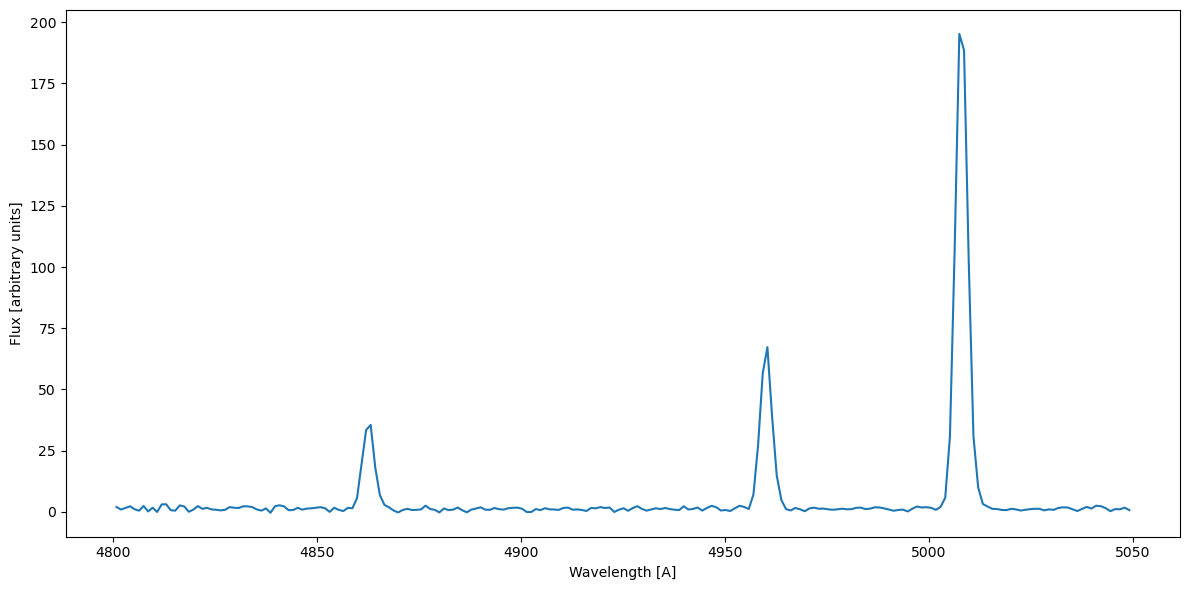

In [5]:
o3_mask = np.logical_and(rest_wavelength > 4800, rest_wavelength < 5050)

plt.figure(figsize=(12, 6))
plt.plot(rest_wavelength[o3_mask], flux[o3_mask])
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [arbitrary units]')
plt.tight_layout()

We already know the values for the central wavelength, and we can put the other values into the **GaussianFitter** provided by the ``pyMultiFit`` library,

<Axes: title={'center': 'O[III] & H_$\\beta$'}, xlabel='Wavelength [A]', ylabel='Flux'>

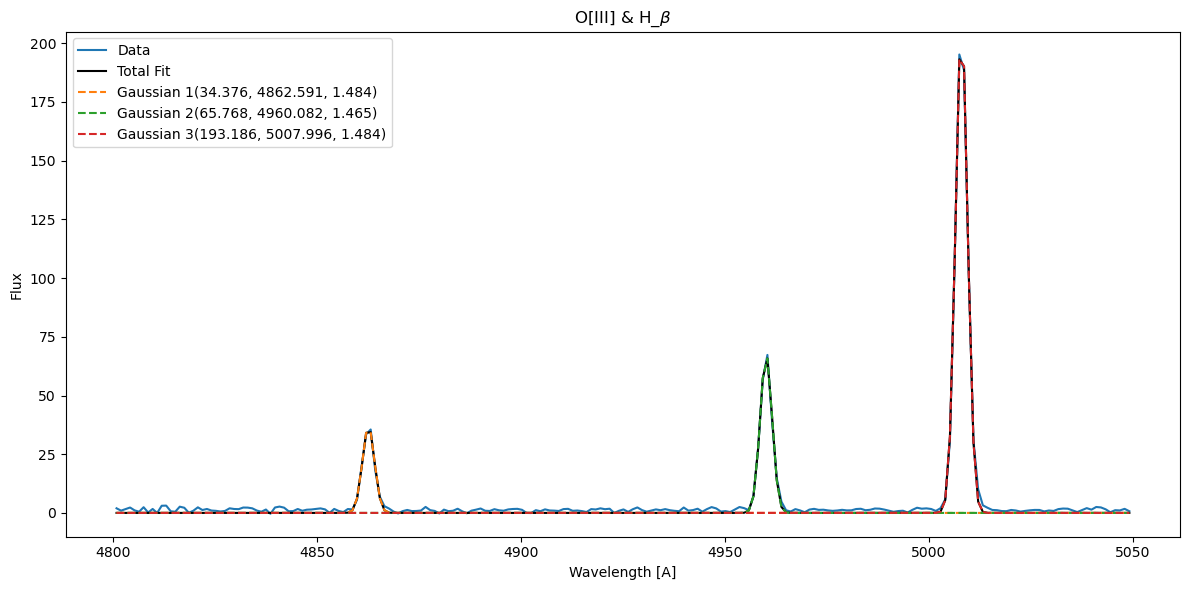

In [6]:
gf_o3 = GaussianFitter(rest_wavelength[o3_mask], flux[o3_mask])
o3_mean = [4860, 4960, 5008]
o3_amp = [20, 70, 150]
o3_std = [1, 1, 1]

guess = np.column_stack([o3_amp, o3_mean, o3_std])

gf_o3.fit(p0=guess)
f, ax = plt.subplots(1, 1, figsize=(12, 6))
gf_o3.plot_fit(show_individual=True, x_label='Wavelength [A]', y_label='Flux', title=r'O[III] & H_$\beta$', axis=ax)

The values are quite close, which is good.
Now let's see those for $H_\alpha$ and ``N[II]``

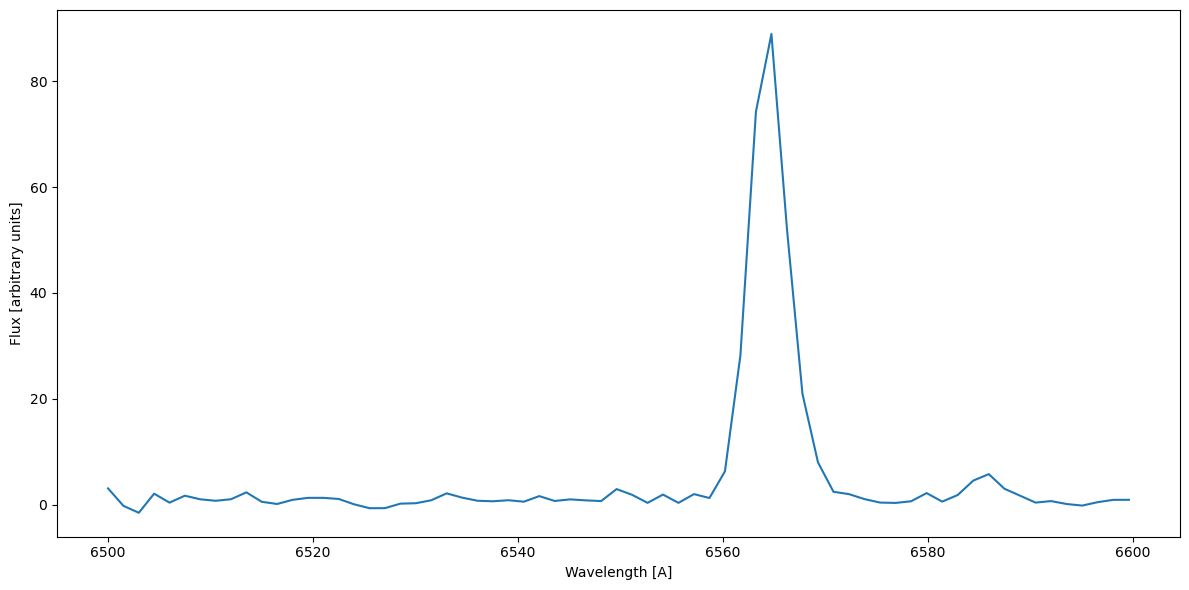

In [7]:
hn_mask = np.logical_and(rest_wavelength > 6500, rest_wavelength < 6600)

plt.figure(figsize=(12, 6))
plt.plot(rest_wavelength[hn_mask], flux[hn_mask])
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [arbitrary units]')
plt.tight_layout()

The `N[II]` lines aren't as prominent here as one would expect.
We can fit $H_\alpha = 6564\,A$ and `N[II]` at $6586\,A$.

<Axes: title={'center': 'N[II] & H_$\\alpha$'}, xlabel='Wavelength [A]', ylabel='Flux'>

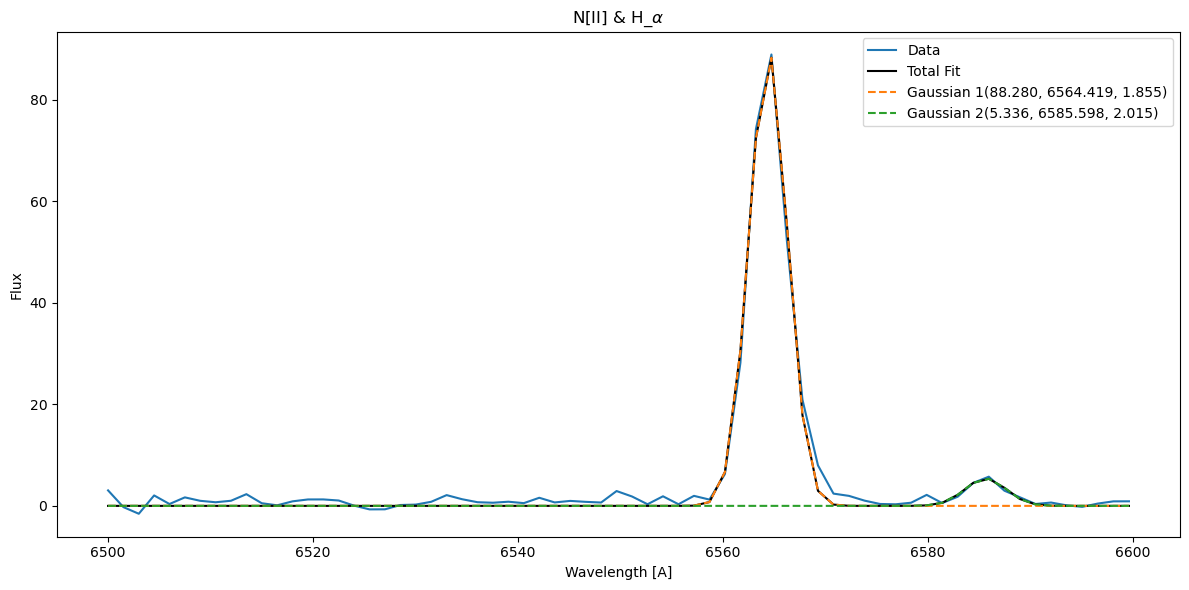

In [8]:
gf_hn = GaussianFitter(rest_wavelength[hn_mask], flux[hn_mask])
hm_amp = [80, 5]
hn_mean = [6562, 6585]
hn_sigma = [1, 1]

guess = np.column_stack([hm_amp, hn_mean, hn_sigma])

gf_hn.fit(p0=guess)
f2, ax = plt.subplots(1, 1, figsize=(12, 6))
gf_hn.plot_fit(show_individual=True, x_label='Wavelength [A]', y_label='Flux', title=r'N[II] & H_$\alpha$', axis=ax)

Although the data is fitted, but the `N[II]` peak isn't that much prominent.
In order to retrieve the parameters we can use the `get_parameter` function from the fitter class.

In [12]:
o3fitted_amp, o3fitted_mean, o3fitter_sigma = gf_o3.get_parameters()

np.column_stack([o3fitted_amp, o3fitted_mean, o3fitter_sigma]).T

array([[3.43763736e+01, 6.57683946e+01, 1.93186365e+02],
       [4.86259136e+03, 4.96008186e+03, 5.00799577e+03],
       [1.48360132e+00, 1.46521195e+00, 1.48385852e+00]])

But for the ``gf_nh``, let's say we don't want to get the value of the `N[II]` fitter, for that, we can use the `select` argument that takes the component number to return the value of.
In this example, we only want to retrieve the value of $H_\alpha$, which is **Gaussian1**, 

In [17]:
nhfitted_amp, nhfitted_mean, nhfitter_sigma = gf_hn.get_parameters(select=[1])

np.column_stack([nhfitted_amp, nhfitted_mean, nhfitter_sigma]).T

array([[8.82800959e+01],
       [6.56441907e+03],
       [1.85548497e+00]])

This is good and all, but what about the error values?

For that we need to pass in ``True`` for errors argument as well. The output is given in the form of two tuples, one containing the mean values, and the other containing the error values computed from the covariance matrix.

In [19]:
mean, errs = gf_hn.get_parameters(select=[1], errors=True)

In [23]:
for m, e in zip(mean, errs):
    print(f'{m[0]} +/- {e[0]}')

88.2800959160333 +/- 1.234429387996434
6564.419066414277 +/- 0.029956644265933703
1.8554849722195768 +/- 0.029938145915926216


Which concludes this tutorial.